In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## Module 1

I first simply solve numerical module 1 and see that i get the right resistance.

Reaction rates satisfying detailed balance:
Reaction 1: k+ = 1.0000, k- = 0.1347, K_eq = 7.4235
Reaction 2: k+ = 0.8000, k- = 1.7837, K_eq = 0.4485
Reaction 3: k+ = 0.6000, k- = 0.1802, K_eq = 3.3294


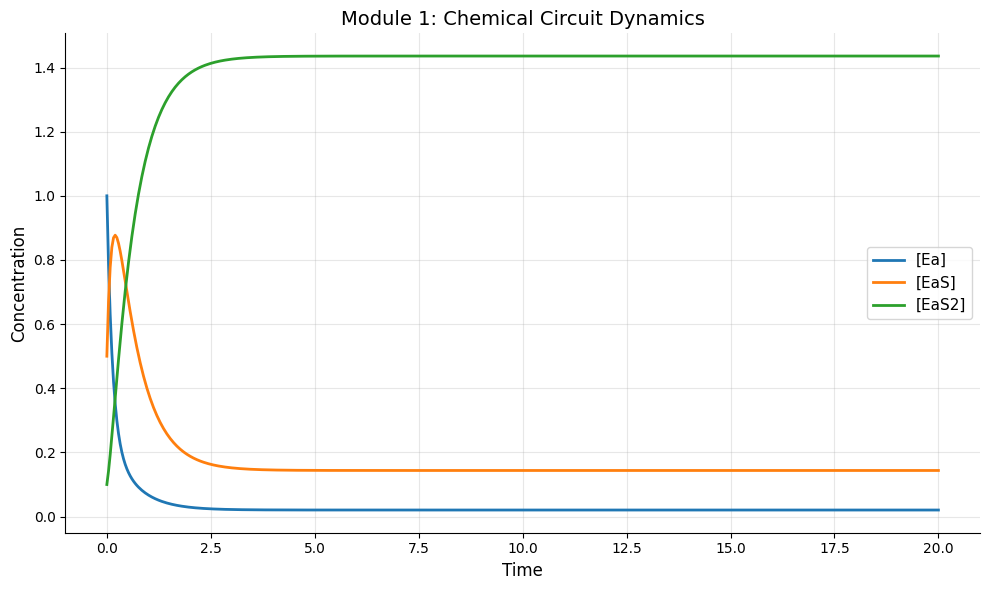


Steady state concentrations:
[Ea]   = 0.0205
[EaS]  = 0.1437
[EaS2] = 1.4358


In [7]:
# Module 1: Chemical circuit with species Ea, EaS, EaS2
# External species: S, Na (fixed concentrations)
# Internal species: Ea, EaS, EaS2 (dynamic)

# Stoichiometric matrix for Module 1 (from paper Eq. 45):
# ∇_x (internal species: Ea, EaS, EaS2) x (reactions: 1, 2, 3)
nabla_x = np.array([
    [-1,  1,  0],  # Ea
    [ 1, -1, -1],  # EaS
    [ 0,  0,  1]   # EaS2
])

# Thermodynamic parameters
R = 8.314  # Gas constant (J/(mol·K))
T = 300    # Temperature (K)
RT = R * T

# Standard chemical potentials (J/mol) - these define the equilibrium
mu0_Ea = 0.0
mu0_EaS = -5000.0
mu0_EaS2 = -8000.0
mu0_S = 0.0
mu0_Na = -3000.0

# Forward reaction rate constants (arbitrary choice)
k1_plus = 1.0
k2_plus = 0.8
k3_plus = 0.6

# Backward rates determined by detailed balance (Eq. 4 in paper):
# RT * log(k+/k-) = -∇^T μ0
# For reaction ρ: k_minus = k_plus * exp(∇^T μ0 / RT)

# Reaction 1: Ea + S -> EaS
# ∇^T μ0 = μ0_EaS - μ0_Ea - μ0_S
delta_G1 = mu0_EaS - mu0_Ea - mu0_S
k1_minus = k1_plus * np.exp(delta_G1 / RT)

# Reaction 2: EaS -> Ea + Na
# ∇^T μ0 = μ0_Ea + μ0_Na - μ0_EaS
delta_G2 = mu0_Ea + mu0_Na - mu0_EaS
k2_minus = k2_plus * np.exp(delta_G2 / RT)

# Reaction 3: EaS + S -> EaS2
# ∇^T μ0 = μ0_EaS2 - μ0_EaS - μ0_S
delta_G3 = mu0_EaS2 - mu0_EaS - mu0_S
k3_minus = k3_plus * np.exp(delta_G3 / RT)

print("Reaction rates satisfying detailed balance:")
print(f"Reaction 1: k+ = {k1_plus:.4f}, k- = {k1_minus:.4f}, K_eq = {k1_plus/k1_minus:.4f}")
print(f"Reaction 2: k+ = {k2_plus:.4f}, k- = {k2_minus:.4f}, K_eq = {k2_plus/k2_minus:.4f}")
print(f"Reaction 3: k+ = {k3_plus:.4f}, k- = {k3_minus:.4f}, K_eq = {k3_plus/k3_minus:.4f}")

# External species concentrations (fixed by chemostats)
S = 3.0   # concentration of S
Na = 2.0  # concentration of Na

def reaction_currents(y):
    """
    Compute reaction currents j1, j2, j3 based on mass action kinetics
    Equation (51) from paper
    
    y[0] = [Ea]
    y[1] = [EaS]
    y[2] = [EaS2]
    """
    Ea, EaS, EaS2 = y
    
    # Reaction 1: Ea + S <-> EaS
    j1 = k1_plus * S * Ea - k1_minus * EaS
    
    # Reaction 2: EaS <-> Ea + Na
    j2 = k2_plus * EaS - k2_minus * Na * Ea
    
    # Reaction 3: EaS + S <-> EaS2
    j3 = k3_plus * S * EaS - k3_minus * EaS2
    
    return np.array([j1, j2, j3])

def module1_ode(y, t):
    """
    ODE system for Module 1
    d[X]/dt = ∇_x @ j
    where X = [Ea, EaS, EaS2]^T and j = [j1, j2, j3]^T
    """
    j = reaction_currents(y)
    dydt = nabla_x @ j
    return dydt

# Initial concentrations
y0 = [1.0, 0.5, 0.1]  # [Ea]_0, [EaS]_0, [EaS2]_0

# Time span
t = np.linspace(0, 20, 500)

# Solve ODE
solution = odeint(module1_ode, y0, t)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, solution[:, 0], label='[Ea]', linewidth=2)
plt.plot(t, solution[:, 1], label='[EaS]', linewidth=2)
plt.plot(t, solution[:, 2], label='[EaS2]', linewidth=2)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Concentration', fontsize=12)
plt.title('Module 1: Chemical Circuit Dynamics', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print steady state values
print("\nSteady state concentrations:")
print(f"[Ea]   = {solution[-1, 0]:.4f}")
print(f"[EaS]  = {solution[-1, 1]:.4f}")
print(f"[EaS2] = {solution[-1, 2]:.4f}")

In [ ]:
# Compute resistance from numerics and compare to analytical
print("Resistance Matrix: Numerical vs Analytical")
print("="*60)

# Steady state from ODE
state_ss = solution[-1]
j_ss = reaction_currents(state_ss)

print("Steady state currents:")
print(f"  j1 = {j_ss[0]:.6f}")
print(f"  j2 = {j_ss[1]:.6f}")
print(f"  j3 = {j_ss[2]:.6f}")

# Chemical potentials at steady state
mu_Ea = mu0_Ea + RT * np.log(state_ss[0])
mu_EaS = mu0_EaS + RT * np.log(state_ss[1])
mu_EaS2 = mu0_EaS2 + RT * np.log(state_ss[2])
mu_S = mu0_S + RT * np.log(S)
mu_Na = mu0_Na + RT * np.log(Na)

# Reaction affinities (the driving forces)
f1 = -(mu_EaS - mu_Ea - mu_S)
f2 = -(mu_Ea - mu_EaS + mu_Na)
f3 = -(mu_EaS2 - mu_EaS - mu_S)

print("\nReaction affinities:")
print(f"  f1 = {f1:.2f} J/mol")
print(f"  f2 = {f2:.2f} J/mol")
print(f"  f3 = {f3:.2f} J/mol")

# Individual resistances: r_ρ = f_ρ / j_ρ (Eq. 33)
r1 = f1 / j_ss[0]
r2 = f2 / j_ss[1]
r3 = f3 / j_ss[2] if abs(j_ss[2]) > 1e-10 else 0.0

print("\nIndividual reaction resistances (r = f/j):")
print(f"  r1 = {r1:.4f} J·s/mol²")
print(f"  r2 = {r2:.4f} J·s/mol²")
print(f"  r3 = {r3:.4f} J·s/mol²")

# Resistance matrix (diagonal)
r_matrix = np.diag([r1, r2, r3])

# Cycle matrix C for Module 1 (from paper Eq. 53)
# From Eq. 22: j = C·J, so for Module 1: j1 = J, j2 = J, j3 = 0
C = np.array([[1], [1], [0]])  # reactions 1 and 2 carry the cycle current

print(f"\nCycle matrix C:")
print(C)

# From j = C·J, we get J = C^+ · j where C^+ is the pseudoinverse
# For Module 1: J = j1 = j2 (they should be equal at steady state)
J_cycle = j_ss[0]  # or j_ss[1], they're equal
print(f"\nCycle current: J = j1 = {J_cycle:.6f} mol/s")
print(f"  (verify j2 = {j_ss[1]:.6f})")

# Cycle force: F = C^T · f (Eq. 28)
f_vector = np.array([f1, f2, f3])
F_cycle = C.T @ f_vector
print(f"\nCycle force: F = C^T·f = {F_cycle[0]:.2f} J/mol")

# Should equal μ_S - μ_Na
F_expected = mu_S - mu_Na
print(f"Expected (μ_S - μ_Na): {F_expected:.2f} J/mol ✓")

# Cycle resistance: R = C^T · r · C (Eq. 36)
R_matrix = C.T @ r_matrix @ C
R = R_matrix[0, 0]

print(f"\nCycle resistance: R = C^T · r · C = {R:.4f} J·s/mol²")
print(f"Compare to r1 + r2 = {r1 + r2:.4f} J·s/mol²")

# Verify: F = R · J (Eq. 35)
RJ = R * J_cycle
print(f"\nVerification (F = R·J):")
print(f"  F       = {F_cycle[0]:.2f} J/mol")
print(f"  R·J     = {RJ:.2f} J/mol")
print(f"  Match: {np.abs(F_cycle[0] - RJ) < 0.01} ✓")


Resistance Matrix: Numerical vs Analytical
Steady state currents:
  j1 = 0.042012
  j2 = 0.042012
  j3 = 0.000000

Reaction affinities:
  f1 = 2877.33 J/mol
  f2 = 1133.98 J/mol
  f3 = 0.00 J/mol

Individual reaction resistances (r = f/j):
  r1 = 68487.5744 J·s/mol²
  r2 = 26991.5343 J·s/mol²
  r3 = 0.0000 J·s/mol²

Cycle matrix C:
[[1]
 [1]
 [0]]

Cycle current: J = j1 = 0.042012 mol/s
  (verify j2 = 0.042012)

Cycle force: F = C^T·f = 4011.31 J/mol
Expected (μ_S - μ_Na): 4011.31 J/mol ✓

Cycle resistance: R = C^T · r · C = 95479.1086 J·s/mol²
Compare to r1 + r2 = 95479.1086 J·s/mol²

Verification (F = R·J):
  F       = 4011.31 J/mol
  R·J     = 4011.31 J/mol
  Match: True ✓


In [24]:
# Debug: Check steady state conditions
print("Steady State Verification")
print("="*60)

state_ss = solution[-1]
j_ss = reaction_currents(state_ss)
dydt_ss = module1_ode(state_ss, t[-1])

print("d[X]/dt at final time:")
print(f"  d[Ea]/dt   = {dydt_ss[0]:.2e}")
print(f"  d[EaS]/dt  = {dydt_ss[1]:.2e}")
print(f"  d[EaS2]/dt = {dydt_ss[2]:.2e}")

print(f"\nIs at steady state? {np.allclose(dydt_ss, 0, atol=1e-6)}")

# Check: ∇_x · j = 0
check = nabla_x @ j_ss
print(f"\n∇_x · j:")
print(f"  Ea:   {check[0]:.2e}")
print(f"  EaS:  {check[1]:.2e}")
print(f"  EaS2: {check[2]:.2e}")

# Check detailed balance at steady state
# At steady state for each reaction: f_ρ / j_ρ should be constant (the resistance)
# But also: j_ρ = k+ [reactants] - k- [products]

print("\n" + "="*60)
print("Detailed Balance Check")
print("="*60)

Ea_ss, EaS_ss, EaS2_ss = state_ss

# Reaction 1: Ea + S <-> EaS
forward_1 = k1_plus * S * Ea_ss
backward_1 = k1_minus * EaS_ss
print(f"\nReaction 1 (Ea + S <-> EaS):")
print(f"  Forward rate:  {forward_1:.6f}")
print(f"  Backward rate: {backward_1:.6f}")
print(f"  Net (j1):      {j_ss[0]:.6f}")

# Reaction 2: EaS <-> Ea + Na
forward_2 = k2_plus * EaS_ss
backward_2 = k2_minus * Na * Ea_ss
print(f"\nReaction 2 (EaS <-> Ea + Na):")
print(f"  Forward rate:  {forward_2:.6f}")
print(f"  Backward rate: {backward_2:.6f}")
print(f"  Net (j2):      {j_ss[1]:.6f}")

# The key insight: at NONEQUILIBRIUM steady state, j1 = j2 ≠ 0
# This maintains the cycle current through the system
print(f"\nNonequilibrium steady state: j1 = j2 = {j_ss[0]:.6f} ≠ 0 ✓")


Steady State Verification
d[X]/dt at final time:
  d[Ea]/dt   = -8.83e-12
  d[EaS]/dt  = -4.68e-11
  d[EaS2]/dt = 5.56e-11

Is at steady state? True

∇_x · j:
  Ea:   -8.83e-12
  EaS:  -4.68e-11
  EaS2: 5.56e-11

Detailed Balance Check

Reaction 1 (Ea + S <-> EaS):
  Forward rate:  0.061377
  Backward rate: 0.019364
  Net (j1):      0.042012

Reaction 2 (EaS <-> Ea + Na):
  Forward rate:  0.114999
  Backward rate: 0.072987
  Net (j2):      0.042012

Nonequilibrium steady state: j1 = j2 = 0.042012 ≠ 0 ✓
